In [1]:
from Batman.batman_monsoon import make_lightcurve, make_batman
from Convolve.convolve import tbconvolve, read_tess, read_batman, open_tess_fits, convolve
from Science.generalized_chisquared import make_table

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Make Batman Parameter File
suffix = '_test'
param_names = ['LIGHTCURVE_TABLE','PARAMETERS_TABLE','LOG_R_MIN','LOG_R_MAX','NUM_R_STEP',
         'LOG_W_MIN','LOG_W_MAX','NUM_W_STEP']
params = ['batmanCurves{}.csv'.format(suffix), 'batmanParams{}.csv'.format(suffix),
          '-1', '-1', '1', '-3.9', '-2.5', '30']
paramfile = 'param{}.txt'.format(suffix)
with open(paramfile, 'w') as f:
    f.write('# Batman Parameter File\n')
    for i in range(len(params)):
        f.write(' = '.join([param_names[i], params[i]]) + '\n')

In [3]:
# Make batman curves
pb = "/home/ctaiudovicic/projects/tess_batman/code/"
bparams, bcurves = make_batman(paramfile, pb, norm=True, write=True)

Generating curves
Batman curve0 failed
Batman curve1 failed
Batman curve2 failed
Batman curve3 failed
Batman curve4 failed
Batman curve5 failed
Batman curve6 failed
Batman curve7 failed
Batman curve8 failed
Batman curve9 failed
Generated 290/300 curves in 0.4593677520751953 s


/home/ctaiudovicic/projects/tess_batman/code/Batman/batman_monsoon.py:80: RuntimeWarning: invalid value encountered in arccos
  lim = np.arccos((1 + r)/(a))/(2 * np.pi) * 360
/home/ctaiudovicic/projects/tess_batman/code/Batman/batman_monsoon.py:118: RuntimeWarning: invalid value encountered in true_divide
  c = (c-cmin)/(cmax-cmin) # scale to [0,1]


Writing files
Wrote files in 0.4670748710632324 s


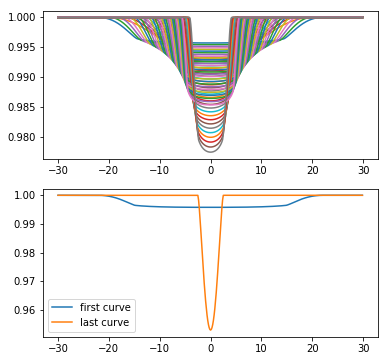

In [4]:
# A bunch of curves
f, axs = plt.subplots(2, figsize=(6,6))
for curveID in bcurves.colnames[3::5]:
    axs[0].plot(bcurves['times'], bcurves[curveID])
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[1]], label='first curve')
axs[1].plot(bcurves['times'], bcurves[bcurves.colnames[-1]], label='last curve')
plt.legend()

Reading TESS from /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0, s:0, e:10...
Reading Batman transit curves...
batmanCurves_test.csv
Starting convolutions...


/home/ctaiudovicic/anaconda3/envs/astro/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Convolved 290 curves in 0.584 s


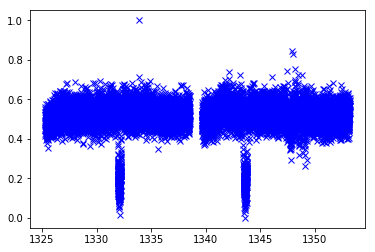

In [5]:
# pt = "/home/ctaiudovicic/projects/tess_batman/data/TESS/"
pt = "/home/ctaiudovicic/projects/tess_batman/sampleData/"
tstart = 0
tend = 10
tess_names = read_tess(pt, pt+"sample_Sector0", tstart, tend)
times, curve_names, batmanCurves = read_batman(pb, suffix)
tess_time, tess_flux = open_tess_fits(tess_names[0], norm=True)
curves, times, convs = convolve(tess_time, tess_flux, batmanCurves, curve_names, num_keep=len(curve_names))

plt.plot(tess_time, tess_flux, 'bx')

In [6]:
candidates = tbconvolve(pt, pb, suffix, 0, tstart, tend, pb, num_keep = -1, norm_tess=True, write=True)

===START TCONVOLVE===
Reading TESS from sample_Sector0, s:0, e:10...
Found 10 TESS files to process
Reading Batman transit curves...
batmanCurves_test.csv
Found 290 Batman curves
Starting TESS file: HD_1397_b.fits
Starting convolutions...


/home/ctaiudovicic/anaconda3/envs/astro/lib/python3.7/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


Convolved 290 curves in 0.499 s
Starting TESS file: HD_202772_A_b.fits
Starting convolutions...
Convolved 290 curves in 0.5 s
Starting TESS file: HD_219666_b.fits
Starting convolutions...
Convolved 290 curves in 0.493 s
Starting TESS file: LHS_3844_b.fits
Starting convolutions...
Convolved 290 curves in 0.59 s
Starting TESS file: pi_Men_c.fits
Starting convolutions...
Convolved 290 curves in 0.462 s
Starting TESS file: tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Starting convolutions...
Convolved 290 curves in 0.722 s
Starting TESS file: tess2018263035959-s0003-0000000003957254-0123-s_lc.fits
Starting convolutions...
Convolved 290 curves in 0.73 s
Starting TESS file: tess2018349182459-s0006-0000000200319843-0126-s_lc.fits
Starting convolutions...
Convolved 290 curves in 0.372 s
Starting TESS file: tess2018349182459-s0006-0000000404768604-0126-s_lc.fits
Starting convolutions...
Convolved 290 curves in 0.379 s
Starting TESS file: tess2018349182459-s0006-0000000404768847-0126-

In [7]:
import matplotlib.colors as c
start = 10
step = 71

fig = plt.figure(figsize=(8, 4))
cm = c.LinearSegmentedColormap.from_list('mycolors',['blue','red'])
# make colorbar
cmin = int(100*np.nanmin(candidates['correlation']))
cmax = int(100*np.nanmax(candidates['correlation']))
print(cmin, cmax)
if (cmax-cmin > 5):
    step = (cmax-cmin)//5
    if step < 1:
        step = 1
    Z = [[0,0],[0,0]]
    levels = range(cmin,cmax+step,step)
    CS3 = plt.contourf(Z, levels, cmap=cm)
    plt.clf()

    for i, curve in enumerate(bcurves.colnames[start::step]):#, len(candidates)):
        row = candidates[candidates['curveID'] == curve]
        r = (100*float(row['correlation'])-cmin)/(cmax-cmin)
        if r > 1:
            r = 1
        plt.plot(bcurves['times'], bcurves[curve], color=(r, 0, 1-r))
    plt.colorbar(CS3)

36 88


TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 576x288 with 0 Axes>

In [ ]:
best = candidates[np.argmax(candidates['correlation'])]
worst = candidates[np.argmin(candidates['correlation'])]

# Search for dip
ind = np.argmin(tess_flux[:15700])
size = len(bcurves['times'])//2
s = ind-size
e = ind+size
mid = (e+s)//2

# Plot lightcurve, best and worst fits
f, axs = plt.subplots(2, figsize=(6,6))

testcurve = 'curve59'
axs[0].plot(tess_time[s:e], 1-bcurves[testcurve], label=testcurve)

axs[0].plot(tess_time[s:e], 1-bcurves[best['curveID']], label='best fit '+best['curveID'])
axs[0].plot(tess_time[s:e], 1-bcurves[worst['curveID']], label='worst fit '+worst['curveID'])
axs[1].plot(tess_time[s:e], 1-tess_flux[s:e])


axs[0].set_title("Min lightcurve dip at t={:.3f}".format(tess_time[ind]))
axs[0].legend()

In [ ]:
# max convolutions of each curve
plt.plot(convs)

In [ ]:
# manual convolve and plots
from scipy.signal import fftconvolve
plot = True


cnames = np.append(curve_names[0::50], best['curveID'])
nplots = len(cnames)+1
fig, axs = plt.subplots(nplots,2, figsize=(11, nplots*2))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.5)
for i, curvename in enumerate(cnames):
    batman_curve = batmanCurves[curvename]
    conv = np.abs(fftconvolve(1-tess_flux, (1-batman_curve), 'same'))
    ind_max = np.argmax(conv)
    conv_max = conv[ind_max]
    
    print(curvename, tess_time[ind_max], conv_max)
    axs[i,0].plot(tess_time, conv, '+')
    axs[i,1].plot(tess_time[s:e], conv[s:e], '+')
    axs[i,0].set_title("Conv: {}".format(curvename))
    axs[i,1].set_title("max_conv={:.4f}".format(conv_max))

     
axs[-1,0].plot(tess_time, 1-tess_flux, 'yx')
axs[-1,1].plot(tess_time[s:e], 1-tess_flux[s:e], 'yx')
axs[-1,0].set_title("Light curve: {}".format(tess_names[0].split("/")[-1]))


In [8]:
params_file = "batmanParams_test.csv"
candidates_file = "candidates_sector0_s0_e9.csv"
make_table(pt, params_file, candidates_file)

Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/HD_1397_b.fits


/home/ctaiudovicic/projects/tess_batman/code/Science/generalized_chisquared.py:82: RuntimeWarning: invalid value encountered in greater
  outcounts = np.nan_to_num(pdcsap_fluxes[pdcsap_fluxes > np.nanmean(pdcsap_fluxes)])


Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/HD_202772_A_b.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/HD_219666_b.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/LHS_3844_b.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/pi_Men_c.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/tess2018263035959-s0003-0000000003836541-0123-s_lc.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/tess2018263035959-s0003-0000000003957254-0123-s_lc.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/tess2018349182459-s0006-0000000200319843-0126-s_lc.fits


/home/ctaiudovicic/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ctaiudovicic/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ctaiudovicic/projects/tess_batman/code/Science/generalized_chisquared.py:90: RuntimeWarning: overflow encountered in square
  reduced_chi_squared = np.nansum(((normalized_fluxes - make_lightcurve(T0, RP, INC, PER, width, u_type, u_param, t)) ** 2 / normalized_sigma ** 2) / 8)
/home/ctaiudovicic/anaconda3/envs/astro/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/tess2018349182459-s0006-0000000404768604-0126-s_lc.fits
Opened file  /home/ctaiudovicic/projects/tess_batman/sampleData/sample_Sector0/tess2018349182459-s0006-0000000404768847-0126-s_lc.fits
Wrote table chisquared_values.csv in 21.2072594165802 s


In [9]:
import pandas as pd
chisq_file = "chisquared_values.csv"
chisq = pd.read_csv(chisq_file)

In [10]:
chisq.sort_values('reducedChiSq').head(20)

,sector,tessFile,curveID,tcorr,correlation,rp,i,width,u,ld,t0,e,w,reducedChiSq
882,sample_Sector0,LHS_3844_b.fits,curve22,1326.746382,0.754327,0.1,75.784227,0.000157,0.1 0.3,quadratic,0.0,0.0,0.0,265.522147
883,sample_Sector0,LHS_3844_b.fits,curve23,1326.742216,0.754669,0.1,68.676340,0.000157,0.1 0.3,quadratic,0.0,0.0,0.0,266.413616
891,sample_Sector0,LHS_3844_b.fits,curve31,1326.736660,0.754961,0.1,83.427869,0.000176,0.1 0.3,quadratic,0.0,0.0,0.0,267.035815
890,sample_Sector0,LHS_3844_b.fits,curve30,1326.736660,0.754897,0.1,90.000000,0.000176,0.1 0.3,quadratic,0.0,0.0,0.0,267.036611
893,sample_Sector0,LHS_3844_b.fits,curve33,1326.735271,0.755544,0.1,70.283606,0.000176,0.1 0.3,quadratic,0.0,0.0,0.0,267.073665
884,sample_Sector0,LHS_3844_b.fits,curve24,1326.738049,0.755182,0.1,61.568453,0.000157,0.1 0.3,quadratic,0.0,0.0,0.0,267.073785
874,sample_Sector0,LHS_3844_b.fits,curve14,1326.738049,0.754168,0.1,58.394344,0.000141,0.1 0.3,quadratic,0.0,0.0,0.0,267.076228
892,sample_Sector0,LHS_3844_b.fits,curve32,1326.733882,0.755175,0.1,76.855738,0.000176,0.1 0.3,quadratic,0.0,0.0,0.0,267.158081
894,sample_Sector0,LHS_3844_b.fits,curve34,1326.729716,0.756019,0.1,63.711475,0.000176,0.1 0.3,quadratic,0.0,0.0,0.0,267.188716
1155,sample_Sector0,LHS_3844_b.fits,curve295,1326.674160,0.779629,0.1,79.822050,0.003162,0.1 0.3,quadratic,0.0,0.0,0.0,267.193937
